In [9]:
!pip install import_ipynb


In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

#from tabulate import tabulate
#from tqdm import trange
import random
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [41]:
device = torch.device('cpu')

In [18]:
from transformers import BertTokenizer, BertForSequenceClassification

In [69]:
model_f = BertForSequenceClassification.from_pretrained("model/food/pytorch_model.bin", config = 'model/food/config.json').to(device)

In [43]:
model_f.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [44]:
print(device)
#model_f = model_f.to(device)

cpu


In [35]:
# 전처리
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [36]:
MAX_LENGTH=150
food_token_id = []
food_attention_masks = []

def preprocessing(input_text, tokenizer,max_len_input=MAX_LENGTH):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = max_len_input,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   )


# 리스트를 텐서로
#food_token_id = torch.cat(food_token_id, dim = 0)
#food_attention_masks = torch.cat(food_attention_masks, dim = 0)
#labels = torch.tensor(labels)

In [45]:
def test_sentence(sentence):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []

    # 전처리
    encoding = preprocessing(sentence, tokenizer)
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = 'Positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    return prediction
    

    
    
new_sentence ='The food was bad, but it was cheap'
# 'It''s good, but the owner is so unkind. Some of the plates didn''t clean properly because there was something on them. But it''s cost-effective.'





print('입력 문장:', new_sentence)
print('분류:', test_sentence(new_sentence))

입력 문장: The food was bad, but it was cheap
분류: Negative


In [46]:
def classifyReviews(textarr):
    i=0
    
    posResult=[] # [[String text,Boolean prediction ], ... ]
    negResult=[] # [[String text,Boolean prediction ], ... ]

    neg=0
    pos=0

    for text in textarr:
        prediction=test_sentence(text)
        if(prediction=="Negative"):
            neg+=1
            negResult.append([text,0])
        else:
            pos+=1
            posResult.append([text,1])

        print("=============================== Input {} ===============================".format(i+1))
        print(text)
        print("model result:",prediction)
        print("")
        i+=1


    print("Positive ratio: {:.4f}".format(pos/len(textarr)))
    print("Negative ratio: {:.4f}".format(neg/len(textarr)))
    return posResult, negResult

In [20]:
def printLenStat(df,colName):
    lendf = pd.DataFrame()
    lendf['length'] = df[colName].apply(len)
    print(lendf.length.describe())

In [48]:
def draw_bar_chart(ratio1, ratio2,title):
    labels = ['Positive', 'Negative']
    ratios = [ratio1, ratio2]

    plt.bar(labels, ratios)
    plt.xlabel('Ratios')
    plt.ylabel('Values')
    plt.title('review : {}'.format(title))
    plt.show()

In [21]:
#naver 실시간 시연

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/sunuri_food.csv'
final_df = pd.read_csv(test_url,sep=',', header=0)
final_df.head(5)

,id,category,text,trans_text
0,0,taste,자주는 못가지만 영통갈때마다 들려요\n너무맛있음 ㅠ 주차장이 좀 더 넓으면 얼마나 좋으꼬,"I can't go often, but I hear it whenever I go ..."
1,1,taste,감자탕에 뼈 양도 많고 살코기도 많이 붙어있어요!!! 당면이랑 떡사리 등 사리 종류...,Pork back-bone soup has a lot of bones and mea...
2,2,taste,친구랑 한뚝빼기 하고 왔어요. 맛나네요^^,I played with my friend. It's delicious ^^
3,3,taste,세상에 가성비 미쳤어요ㅋㅋ학교 앞에서 성공하는데는 다 이유가 있나봐여!! 저희는 직...,The cost-effectiveness is crazyThere must be a...
4,4,taste,뼈해장국 굉장히 맛있네요!,Pork rib hangover soup is really good!


In [22]:
printLenStat(final_df,'trans_text')

count    288.000000
mean      44.364583
std       60.283960
min        9.000000
25%        9.000000
50%       21.500000
75%       47.250000
max      412.000000
Name: length, dtype: float64


In [47]:
final_text=final_df.trans_text.values
final_posResult,final_negResult=classifyReviews(final_text)

=============================== Input 1 ===============================
I can't go often, but I hear it whenever I go to the video call. It's so delicious. How nice would it be if the parking lot was wider
model result: Positive

=============================== Input 2 ===============================
Pork back-bone soup has a lot of bones and meat on it!!! There are various kinds of noodles such as glass noodles and rice cake sari. But I don't like fried rice..
model result: Negative

=============================== Input 3 ===============================
I played with my friend. It's delicious ^^
model result: Positive

=============================== Input 4 ===============================
The cost-effectiveness is crazyThere must be a reason for success in front of the school!! We had a group of office workers, and we ate a lot and drank a lot. I wondered how this was the only amount of moneyLol, the soup is so delicious and adding ramen noodles is a must. ♡ Boss, have a prosperous 

=============================== Input 52 ===============================
It's really good ㅜㅜ. cool
model result: Positive

=============================== Input 53 ===============================
Kyung Hee University's famous restaurant with plenty of food!
model result: Positive

=============================== Input 54 ===============================
I ate it as a hot pot, and there was a variety of sujebi, glass noodles, potatoes, radish, etc. and there was a lot of meat on the bones and I enjoyed it. I'm busy with a lot of customers, but you're kind and the food comes out quickly. I wish there were more standing tables.. It's not greasy and it's delicious?
model result: Positive

=============================== Input 55 ===============================
Because of the sound of a bowl bump. I was so annoyed... but now I don't want to hit the plate. I think I'm being careful. . The staff are kind. The side dishes are fresh and delicious.
model result: Positive

========================

=============================== Input 109 ===============================
It's delicious
model result: Positive

=============================== Input 110 ===============================
My daughter likes gamjatang, so I always visit this place, but as expected, she ate it deliciously. Please use Kyung Hee University's Jeongmun Bone Stew Nuri a lot. Please remember to drive on behalf of the driver when you drink! 1666-9488 chauffeur service map. Please use it a lot! We'll keep you safe! Seoul Gyeonggi mileage 10% cash reserve~^^
model result: Positive

=============================== Input 111 ===============================
It's good
model result: Positive

=============================== Input 112 ===============================
It's good
model result: Positive

=============================== Input 113 ===============================
It's good
model result: Positive

=============================== Input 114 ===============================
It's my first time eating it there, and it'

=============================== Input 172 ===============================
It's good
model result: Positive

=============================== Input 173 ===============================
Kind and delicious
model result: Positive

=============================== Input 174 ===============================
It's still good
model result: Positive

=============================== Input 175 ===============================
It's delicious
model result: Positive

=============================== Input 176 ===============================
I was a bit disappointed with the fried rice
model result: Negative

=============================== Input 177 ===============================
It is delicious.
model result: Positive

=============================== Input 178 ===============================
It's good
model result: Positive

=============================== Input 179 ===============================
It's packed, but it's a lot and it's so good!!! . Please do business for a long time?
model result: Positive

=============================== Input 235 ===============================
It's good
model result: Positive

=============================== Input 236 ===============================
It's good because there's a lot, but the dried radish leaves are tough
model result: Positive

=============================== Input 237 ===============================
It's delicious. Kimchi kkakdugi is the best
model result: Positive

=============================== Input 238 ===============================
Pork back-bone stew is delicious. The claw is ruined ^^. . I enjoyed the chili pepper
model result: Positive

=============================== Input 239 ===============================
It's so good. I'll try the boneless bibimbap next time. Ice cream is also very good after a lot of course
model result: Positive

=============================== Input 240 ===============================
It's good
model result: Positive

=============================== Input 241 ===============================
It's good!!

In [66]:
foodR=[0]*2
foodR[0]=len(final_posResult)/(len(final_posResult)+len(final_negResult))
foodR[1]=len(final_negResult)/(len(final_posResult)+len(final_negResult))

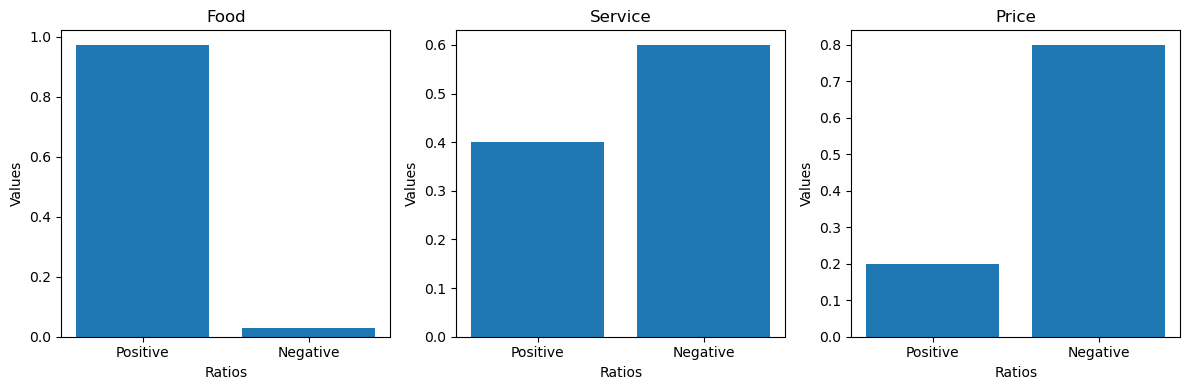

In [67]:
def draw_bar_charts(ratio1, ratio2, ratio3):
    labels = ['Positive', 'Negative']
    ratios = [[ratio1[0], ratio1[1]], [ratio2[0], ratio2[1]], [ratio3[0], ratio3[1]]]

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # 1행 3열의 서브플롯 생성
    catList=['Food','Service','Price']
    
    for i, ax in enumerate(axs):
        ax.bar(labels, ratios[i])
        ax.set_xlabel('Ratios')
        ax.set_ylabel('Values')
        ax.set_title('{}'.format(catList[i]))

    plt.tight_layout()  # 서브플롯 간의 간격 조정
    plt.show()

# 예시 비율 데이터 (각 비율은 2개의 값으로 구성)
ratio1 = [0.7, 0.3]
ratio2 = [0.4, 0.6]
ratio3 = [0.2, 0.8]

draw_bar_charts(foodR, ratio2, ratio3)